# Python Assignment 2: Using post-LASSO on large spatial data

This assignment will give you a real (active) research topic that I've discussed a little bit in class: predicting carbon storage as a function of high-resolution gridded data. In the class google drive you will find all the data you need. I added it just recently so if you don't have it, be sure to go get it first. 

This assignment will have you use the automated variable selection approach within LASSO to deal with a common situation in regressions on raster-stacks: we have so much data everything is significant but will lead to massive overfitting. The basic approach used here will involve reading in 2d rasters, flattening them into a 1d column ready to add to a dataframe shaped object, which we will use as our X matrix.

Please turn in the completed Notebook (.ipynb) file that includes the results you generate. 

Below is some starter code along with specific assignment questions.

In [1]:
# Load libraries
import numpy as np
import os
from osgeo import gdal
from sklearn.linear_model import Lasso
from matplotlib import pyplot as plt
from statsmodels.api import OLS


## Step 1: Download the data and set paths

Download the latest data from the class's google drive. In there, you will need the the files in `Data/python_assignment_2` data and assign a relative path to the `soyo_tile` directory in that assignment directory. It is your task to ensure your script runs in the right location and the data is stored in the right location that this relative path works.

In [2]:
# Step 1 code

data_dir = '../../../Data/python_assignment_2/soyo_tile'

## Step 2: Set raster paths 

Assign each of the raster paths in the directory to a dictionary for later use. I've included most of the code (so you don't have to waste your time typing), but add in the missing paths.

In [3]:
# Step 2 code

raster_paths = {}

# First is the dependent varable, Above Ground Carbon (AGB) in tons, measured at 30 meters globally (here it is clipped to a smaller area)
raster_paths['agb_observed_baccini_2000_30m'] = os.path.join(data_dir, "agb_observed_baccini_2000_30m.tif")

# Here are some of the independent variables
raster_paths['CRFVOL_M_sl1_250m'] = os.path.join(data_dir, "CRFVOL_M_sl1_250m.tif")
raster_paths['HISTPR_250m'] = os.path.join(data_dir, "HISTPR_250m.tif")
raster_paths['OCDENS_M_sl1_250m'] = os.path.join(data_dir, "OCDENS_M_sl1_250m.tif")
raster_paths['PHIHOX_M_sl1_250m'] = os.path.join(data_dir, "PHIHOX_M_sl1_250m.tif")
raster_paths['roughness_30s'] = os.path.join(data_dir, "roughness_30s.tif")
raster_paths['SLGWRB_250m'] = os.path.join(data_dir, "SLGWRB_250m.tif")
raster_paths['SLTPPT_M_sl1_250m'] = os.path.join(data_dir, "SLTPPT_M_sl1_250m.tif")
raster_paths['terrain_ruggedness_index_30s'] = os.path.join(data_dir, "terrain_ruggedness_index_30s.tif")
raster_paths['TEXMHT_M_sl1_250m'] = os.path.join(data_dir, "TEXMHT_M_sl1_250m.tif")
raster_paths['wc2.0_bio_30s_01'] = os.path.join(data_dir, "wc2.0_bio_30s_01.tif")
raster_paths['alt_30s'] = os.path.join(data_dir, "alt_30s.tif")
raster_paths['AWCh1_M_sl1_250m'] = os.path.join(data_dir, "AWCh1_M_sl1_250m.tif")
raster_paths['BDRICM_M_250m'] = os.path.join(data_dir, "BDRICM_M_250m.tif")
raster_paths['BDRLOG_M_250m'] = os.path.join(data_dir, "BDRLOG_M_250m.tif")
raster_paths['BLDFIE_M_sl1_250m'] = os.path.join(data_dir, "BLDFIE_M_sl1_250m.tif")

# ANSWER:
# Here are the 3 missing paths
raster_paths['wc2.0_bio_30s_12'] = os.path.join(data_dir, "wc2.0_bio_30s_12.tif")
raster_paths['CLYPPT_M_sl1_250m'] = os.path.join(data_dir, "CLYPPT_M_sl1_250m.tif")
raster_paths['slope_30s'] = os.path.join(data_dir, "slope_30s.tif")


## Step 3: Open the rasters

Our dependent variable will be 30 meter observations of carbon storage from Baccini et al. (unpublished, but soon to be published) data. The label I assigned in the dictionary above was agb_observed_baccini_2000_30m for this variable. Use gdal.Open, GetRasterBand(1) and ReadAsArray() to read this geotiff as a numpy file

Side note: If you get an error like: "ERROR 4: This is a BigTIFF file.  BigTIFF is not supported by this version of GDAL and libtiff." make sure you have installed gdal with the mamba method from lecture 1. 

In [4]:
# Step 3 code

# Use gdal.Open, GetRasterBand(1) and ReadAsArray() to read this geotiff as a numpy file
files_here = os.path.abspath(data_dir)
ds = gdal.Open(raster_paths['agb_observed_baccini_2000_30m'])
band = ds.GetRasterBand(1)
array = band.ReadAsArray()


## Step 4: Define some arrays

Create an empty numpy array (or full of zeros) of the right shape to house all our raster data. A very CPU-efficient way of arranging a stack of 2d rasters (which would be 3d once stacked up), is to flatten each 2d raster into a longer 1d array. This will go into our X matrix. In order to create the right sized X matrix, first get the n_obs and n_vars by inspecting the dependent variable raster and the dictionary of inputs above. Note that the n_vars should be the number of independent AND dependent variables.

In [5]:
# Step 4 code

#Create an empty numpy array of the right size
n_obs = array.size
n_vars = len(raster_paths)
data_array = np.zeros((n_obs, n_vars))
print(n_obs, n_vars)

4000000 19


## Step 5: Load all the independent variables

- Iterate through the dictionary and load each raster as a 2d array
- flatten it to 1d using the .flatten() method in numpy
- Assign this 1d array to the correct column of the data array. By convention, the depvar will be the first column.

Hint, assuming you have arranged your X array in the correct way, it should have observations (pixels) as rows and variables as cols. Given that each flattened array is for one variable and is as long as there are rows, a convenient way of assigning it would be to use numpy slice notation, potentially similar to:

`data_array[:, column_index_integer]`

The first colon just denotes the whole row and the column index is an integer you could create pointing to the right row.

Some incomplete code to get you started is below.


In [6]:
# Step 5 code

# for name, path in raster_paths.items():
#     print('Loading', path)
#     flattened_raster_array = band.ReadAsArray().flatten()
#     data_array[:, col_index] = flattened_raster_array
#     feature_names.append(name)
    
    
# ANSWER:
# Iterate through the dictionary and load each raster as a 2d array, flatten it to 1d

col_index = 0 
feature_names = []
for name, path in raster_paths.items(): #Iterate through the dictionary
    print('Loading', path)
    ds = gdal.Open(path)                #load each raster as a 2d array
    band = ds.GetRasterBand(1)
    flattened_raster_array = band.ReadAsArray().flatten() #flatten it to 1d
    data_array[:, col_index] = flattened_raster_array
    feature_names.append(name)
    col_index += 1


Loading ../../../Data/python_assignment_2/soyo_tile\agb_observed_baccini_2000_30m.tif
Loading ../../../Data/python_assignment_2/soyo_tile\CRFVOL_M_sl1_250m.tif
Loading ../../../Data/python_assignment_2/soyo_tile\HISTPR_250m.tif
Loading ../../../Data/python_assignment_2/soyo_tile\OCDENS_M_sl1_250m.tif
Loading ../../../Data/python_assignment_2/soyo_tile\PHIHOX_M_sl1_250m.tif
Loading ../../../Data/python_assignment_2/soyo_tile\roughness_30s.tif
Loading ../../../Data/python_assignment_2/soyo_tile\SLGWRB_250m.tif
Loading ../../../Data/python_assignment_2/soyo_tile\SLTPPT_M_sl1_250m.tif
Loading ../../../Data/python_assignment_2/soyo_tile\terrain_ruggedness_index_30s.tif
Loading ../../../Data/python_assignment_2/soyo_tile\TEXMHT_M_sl1_250m.tif
Loading ../../../Data/python_assignment_2/soyo_tile\wc2.0_bio_30s_01.tif
Loading ../../../Data/python_assignment_2/soyo_tile\alt_30s.tif
Loading ../../../Data/python_assignment_2/soyo_tile\AWCh1_M_sl1_250m.tif
Loading ../../../Data/python_assignment_2/s



# Step 6: 

Extract the first array row of the data_array and assign it to y. Assign the rest to X.


In [7]:
# Step 6 code

# Extract the first array row of the data_array
# and assign it to y. Assign the rest to X.
y = data_array[:, 0]
X = data_array[:, 1:]


# Step 7:

Split the X and y into testing and training data such that the training data is the first million pixels and the testing data is the next 200,000. Do this using numpy slice notation on the X and y variables you created.

In [8]:
# Step 7 code

# split the X and y into testing and training data such that
# the training data is the first million pixels and the testing data is the next 200,000
# Do this using numpy slice notation on the X and y variables you created.
X_train = X[:1000000]
X_test = X[1000001:1200000]
y_train = y[:1000000]
y_test = y[1000001:1200000]

# Step 8 (optional but useful):

To make the code run faster, we are going to use every 10th pixel. We can easily get this via numpy slicing again, using x_train[::10] to get every 10th pixel.


In [9]:
# Step 8 code

X_train = X_train[::10]
y_train = y_train[::10]

# Step 9:

Create a Lasso object (using the default penalty term alpha) and fit it to the training data. Create and print out a vector of predicted carbon values. Also print out the score using the lasso object's .score() method on the TESTING data. Print out the fitted lasso score.

In [10]:
# Step 9 code

lasso = Lasso(random_state=0, max_iter=10000)
fitted_lasso = lasso.fit(X_train, y_train) #fit the lasso to the training data
predicted = fitted_lasso.predict(X_test)
score = lasso.score(X_test, y_test)


#print out the predicted carbon values
print('predicted carbon values', predicted)

#print out the score using lasso
print('fitted lasso score', score)

predicted carbon values [ -1.26797484  -1.26797484  -1.26797484 ... 116.53640704 115.79546937
 111.97611889]
fitted lasso score 0.371258572060129


# Step 10, optional and just for fun:.

To view how our projections LOOK, we can create a predicted matrix on the whole X, reshape it back into the original 2d shape and look at it. You can compare this to the input array to visualize how it looks. Note that this will only work if you name your objects like mine.

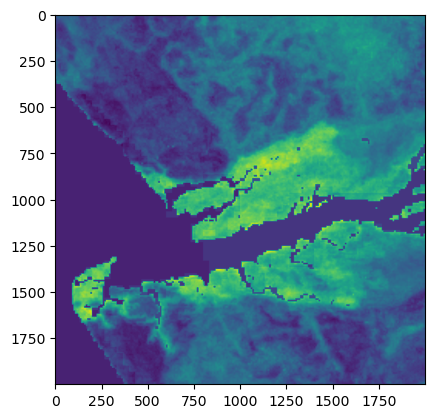

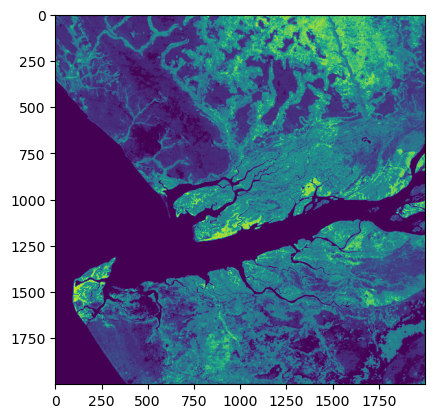

In [11]:
# Step 10 code

full_prediction = fitted_lasso.predict(X)
prediction_2d = full_prediction.reshape(2000, 2000)
plt.imshow(prediction_2d)
plt.show()

plt.imshow(array)
plt.show()


# Step 11:

Create a list of 30 alphas using ` np.logspace(-1, 3, 30)`. 

Using a for loop iterate over those alphas and run the Lasso model like above, but using the alpha values in the loop. Print out the fit score at each step. Using matplotlib, plot how this value changes as alpha changes. Finally, extract the best alpha of the bunch. 

Alpha: 0.1 Score: 0.36101074395266985
Alpha: 0.1373823795883263 Score: 0.36192043018357734
Alpha: 0.18873918221350972 Score: 0.36280944629797485
Alpha: 0.2592943797404667 Score: 0.3637454439109026
Alpha: 0.3562247890262442 Score: 0.36495408213148184
Alpha: 0.4893900918477494 Score: 0.36646627939534626
Alpha: 0.6723357536499337 Score: 0.3682630682852577
Alpha: 0.9236708571873861 Score: 0.37061866052824255
Alpha: 1.2689610031679222 Score: 0.3726704764994868
Alpha: 1.743328822199988 Score: 0.37391996515390546
Alpha: 2.395026619987486 Score: 0.37561090363317395
Alpha: 3.2903445623126677 Score: 0.3812107201184334
Alpha: 4.520353656360243 Score: 0.38827472267002716
Alpha: 6.2101694189156165 Score: 0.40087981782714655
Alpha: 8.531678524172806 Score: 0.41548148998128154
Alpha: 11.721022975334806 Score: 0.4277534596552882
Alpha: 16.102620275609393 Score: 0.4326627395394832
Alpha: 22.12216291070448 Score: 0.42566115347915956
Alpha: 30.39195382313198 Score: 0.4380368762365602
Alpha: 41.7531893656

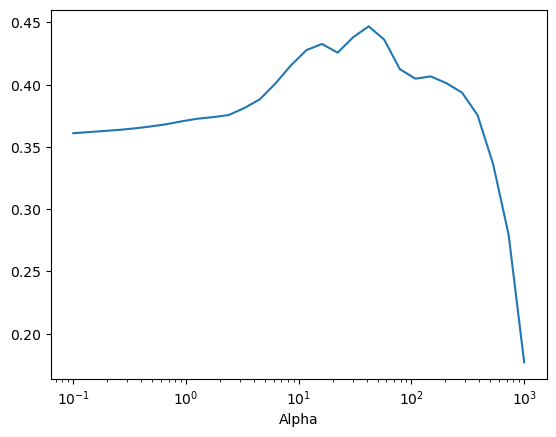

Best alpha 41.753189365604


In [12]:
# Step 11 code

list_scores = []
alphas = np.logspace(-1, 3, 30)

for i in range(len(alphas)):  #following is almost same as Step 9
    alpha = alphas[i]
    new_lasso = Lasso(alpha=alpha)
    fitted_new_lasso = new_lasso.fit(X_train, y_train)
    new_score = new_lasso.score(X_test, y_test)
    list_scores.append(new_score)

    print('Alpha:', alpha, 'Score:', new_score)

plt.semilogx(alphas, list_scores)
plt.xlabel('Alpha')
plt.show()

list_scores_array = np.array(list_scores)
best_score = max(list_scores_array)
chosen_alpha = alphas[list_scores_array == best_score][0]
print('Best alpha', chosen_alpha)

# Step 12: 

Rerun the lasso with that best value and identify all of the coefficiencts that were "selected" ie had non-zero values. Save these coefficient indices and labels to a list.

In [13]:
# Step 12 code

clf = Lasso(alpha=chosen_alpha, random_state=0, max_iter=10000).fit(X_train, y_train)
print("coefficients", clf.coef_)

selected_coefficient_labels = []
selected_coefficient_indices = []
for i in range(len(clf.coef_)):
    # print('Coefficient', feature_names[i], 'was', clf2.coef_[i])
    if abs(clf.coef_[i]) > 0:
        selected_coefficient_labels.append(feature_names[i])
        selected_coefficient_indices.append(i)

coefficients [ 0.          0.          0.46546224 -0.          0.21709184 -0.
 -0.          0.         -0.         -0.         -0.00482475 -0.
  0.28428479  0.         -0.19214719  0.16611704  2.21406191  0.        ]



# Step 13:

Using Statsmodels, run an OLS version on the selected variables.

Use print to show the results table.

Write a description of any advantages this approach has over vanilla OLS.






In [14]:
# Step 13 code

new_x = X[:, selected_coefficient_indices]
result = OLS(y, new_x).fit().summary()
print(result)
result_vOLS = OLS(y, X).fit().summary()
print(result_vOLS)



                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.801
Model:                            OLS   Adj. R-squared (uncentered):              0.801
Method:                 Least Squares   F-statistic:                          2.295e+06
Date:                Tue, 27 Dec 2022   Prob (F-statistic):                        0.00
Time:                        13:01:36   Log-Likelihood:                     -2.0795e+07
No. Observations:             4000000   AIC:                                  4.159e+07
Df Residuals:                 3999993   BIC:                                  4.159e+07
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------